In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm

from cplAE_TE.utils.analysis_helpers import pc_cca, supervised_classification
from cplAE_TE.utils.load_helpers import get_paths, load_dataset, load_summary_files

#### Supervised classification

Representations of transcriptomics and electrophysiological data obtained with autoencoders in the uncoupled and coupled settings are used to perform supervised classification to identify reference transcriptomic cell types and classes at different resolutions of the [Tasic et al. 2018](https://www.nature.com/articles/s41586-018-0654-5) hierarchy. 

In [2]:
O = load_dataset(min_sample_thr=10)
path = get_paths()

In [3]:

#Experiment configurations for supervised classification:
config = {}

config['uncoupled_zT'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                          'lambda_TE': 0.0, 'aug': 0, 'representation_id': 'zT'}

config['uncoupled_zE'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                          'lambda_TE': 0.0, 'aug': 0, 'representation_id': 'zE'}

config['coupled_0-5_zT'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                            'lambda_TE': 0.5, 'aug': 1, 'representation_id': 'zT'}

config['coupled_0-5_zE'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                            'lambda_TE': 0.5, 'aug': 1, 'representation_id': 'zE'}

config['coupled_1-0_zT'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                            'lambda_TE': 1.0, 'aug': 1, 'representation_id': 'zT'}

config['coupled_1-0_zE'] = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
                            'lambda_TE': 1.0, 'aug': 1, 'representation_id': 'zE'}

In [4]:

for key in config.keys():
    print(f'\nStarting experiment {key}')
    cfg = config[key]

    #Get saved representations
    path = get_paths()
    CVdict = load_summary_files(data_type='NM',
                                alpha_T=cfg['alpha_T'],
                                alpha_E=cfg['alpha_E'],
                                lambda_TE=cfg['lambda_TE'],
                                latent_dim=cfg['latent_dim'],
                                aug=cfg['aug'],
                                fold_list=np.arange(cfg['n_cvfolds']))

    #Perform supervised classification (representation --> t-type, k-fold cross-validation)
    result_df_list = []
    for cv in tqdm(CVdict.keys()):
        result_df = supervised_classification(
            CVdict[cv], representation_id=cfg['representation_id'])
        result_df['representation_id'] = cfg['representation_id']
        result_df['fold'] = cv
        result_df_list.append(result_df)

    #Save result for all folds
    result_df = pd.concat(result_df_list)

    fname = f'{cfg["representation_id"]}_to_ttype' +\
        f'_aT_{cfg["alpha_T"]:0.1f}' +\
        f'_aE_{cfg["alpha_E"]:0.1f}' +\
        f'_cs_{cfg["lambda_TE"]:0.1f}' +\
        f'_ad_{cfg["aug"]:d}' +\
        f'_ld_{cfg["latent_dim"]:d}'
    fname = fname.replace('.', '-')+'.csv'
    result_df.to_csv('../assets/'+fname)
    


Starting experiment uncoupled_zT
Loading aT_1-0_aE_1-0_cs_0-0_ad_0
100%|██████████| 44/44 [01:50<00:00,  2.52s/it]

Starting experiment uncoupled_zE
Loading aT_1-0_aE_1-0_cs_0-0_ad_0
100%|██████████| 44/44 [01:49<00:00,  2.49s/it]

Starting experiment coupled_0-5_zT
Loading aT_1-0_aE_1-0_cs_0-5_ad_1
100%|██████████| 44/44 [01:49<00:00,  2.48s/it]

Starting experiment coupled_0-5_zE
Loading aT_1-0_aE_1-0_cs_0-5_ad_1
100%|██████████| 44/44 [01:49<00:00,  2.49s/it]

Starting experiment coupled_1-0_zT
Loading aT_1-0_aE_1-0_cs_1-0_ad_1
100%|██████████| 44/44 [01:50<00:00,  2.52s/it]

Starting experiment coupled_1-0_zE
Loading aT_1-0_aE_1-0_cs_1-0_ad_1
100%|██████████| 44/44 [01:50<00:00,  2.50s/it]


#### Supervised classification with PC-CCA representations

The training and validation splits are identical to those used for coupled autoencoder experiments. Centered and whitened canonical component projections are used as input to the supervised classifier. 

In [5]:
O = load_dataset(min_sample_thr=10)
path = get_paths()

In [6]:
#CVdict only loads indices (training, validation, ...):
cfg = {'alpha_T': 1.0, 'alpha_E': 1.0, 'latent_dim': 3, 'n_cvfolds': 44,
       'lambda_TE': 1.0, 'aug': 1, 'representation_id': 'zT'}
key_list = ['train_ind', 'val_ind', 'test_ind']

path = get_paths()
CVdict = load_summary_files(data_type='NM',
                            alpha_T=cfg['alpha_T'],
                            alpha_E=cfg['alpha_E'],
                            lambda_TE=cfg['lambda_TE'],
                            latent_dim=cfg['latent_dim'],
                            aug=cfg['aug'],
                            fold_list=np.arange(cfg['n_cvfolds']),
                            key_list=key_list)

del cfg

Loading aT_1-0_aE_1-0_cs_1-0_ad_1


In [7]:
config = {}

config['50-50-pc-3-cc_zT'] = {'pc_dim_T': 50, 'pc_dim_E': 50,
                           'cca_dim': 3, 'representation_id': 'zT'}

config['50-50-pc-3-cc_zE'] = {'pc_dim_T': 50, 'pc_dim_E': 50,
                           'cca_dim': 3, 'representation_id': 'zE'}

config['10-10-pc-3-cc_zT'] = {'pc_dim_T': 10, 'pc_dim_E': 10,
                           'cca_dim': 3, 'representation_id': 'zT'}

config['10-10-pc-3-cc_zE'] = {'pc_dim_T': 10, 'pc_dim_E': 10,
                           'cca_dim': 3, 'representation_id': 'zE'}

In [8]:
for key in config.keys():
    print(f'\nStarting experiment {key}')
    cfg = config[key]

    #For each of the folds, perform pc-cca with the same training/validation splits and obtain the representations.
    for cv in CVdict.keys():
        CVdict[cv]['zT'], CVdict[cv]['zE'], *_ = pc_cca(XT=deepcopy(O['XT']),
                                                        XE=deepcopy(O['XE']),
                                                        train_ind=CVdict[cv]['train_ind'],
                                                        pc_dim_T=cfg['pc_dim_T'],
                                                        pc_dim_E=cfg['pc_dim_E'],
                                                        cca_dim=cfg['cca_dim'])

    #Perform supervised classification (representation --> t-type, k-fold cross-validation)
    result_df_list = []
    for cv in tqdm(CVdict.keys()):
        result_df = supervised_classification(
            CVdict[cv], representation_id=cfg['representation_id'])
        result_df['representation_id'] = cfg['representation_id']
        result_df['fold'] = cv
        result_df_list.append(result_df)

    #Save result for all folds
    result_df = pd.concat(result_df_list)

    fname = f'{cfg["representation_id"]}_to_ttype' +\
        f'_pc_dim_T_{cfg["pc_dim_T"]:d}' +\
        f'_pc_dim_E_{cfg["pc_dim_E"]:d}' +\
        f'_cca_dim_{cfg["cca_dim"]:d}'
    fname = fname.replace('.', '-')+'.csv'
    result_df.to_csv('../assets/'+fname)


Starting experiment 50-50-pc-3-cc_zT
100%|██████████| 44/44 [01:50<00:00,  2.50s/it]

Starting experiment 50-50-pc-3-cc_zE
100%|██████████| 44/44 [01:51<00:00,  2.53s/it]

Starting experiment 10-10-pc-3-cc_zT
100%|██████████| 44/44 [01:49<00:00,  2.49s/it]

Starting experiment 10-10-pc-3-cc_zE
100%|██████████| 44/44 [01:49<00:00,  2.48s/it]


#### Plot results for classification into t-types using different representations. 

In obtaining coupled autoencoder representations, no information about the transcriptomic type labels (t-types) of cells is used. Those labels were obtained independently using marker gene expression. The details of mapping can be found in [Gouwens et al. 2020](https://www.sciencedirect.com/science/article/pii/S009286742031254X). 

The points demonstrated with this analysis are:
 - $\lambda_{te}$ behaves as expected (the representations, and hence classification results become similar as this parameter is increased)
 - t-types are hard to identify in representations of electrophysiology alone ($z_e$, $\lambda_{te} = 0$)
 - Representations with non-linear dimensionality reduction outperform those obtained by simple linear baselines for supervised t-types classification
 - Performance drops as the number of classes increases. Imbalance in the class-wise distribution of samples, low number of samples for some classes both contribute to this.

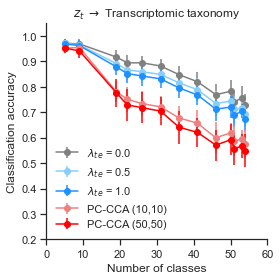

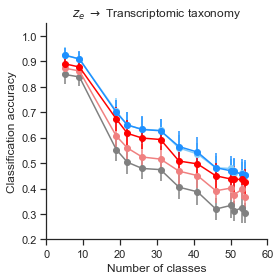

In [9]:
sns.set()
sns.set_style('ticks', {'axes.grid': False})
%matplotlib inline

representation_id_txt = ['z_t', 'z_e']
for txt_ind, representation_id in enumerate(['zT', 'zE']):
    res_pth = Path('../assets/')
    fname_list = [f'{representation_id:s}_to_ttype_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3.csv',
                    f'{representation_id:s}_to_ttype_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3.csv',
                    f'{representation_id:s}_to_ttype_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3.csv',
                    f'{representation_id:s}_to_ttype_pc_dim_T_10_pc_dim_E_10_cca_dim_3.csv',
                    f'{representation_id:s}_to_ttype_pc_dim_T_50_pc_dim_E_50_cca_dim_3.csv']
                    
    col = ['gray',
            'lightskyblue',
            'dodgerblue',
            'lightcoral',
            'red']

    lbl = [r'$\lambda_{te}$ = 0.0',
            r'$\lambda_{te}$ = 0.5',
            r'$\lambda_{te}$ = 1.0',
            'PC-CCA (10,10)',
            'PC-CCA (50,50)']
    df_list = [pd.read_csv((res_pth / fname).resolve()) for fname in fname_list]
    
    plt.figure(figsize=(4, 4))
    for i, df in enumerate(df_list):
        x_ = []
        y_ = []
        yerr_ = []
        for n in np.unique(df['n_components'].values):
            ind = df['n_components'].values == n
            x_.append(n)
            y_.append(np.mean(df['acc_val'].values[ind]))
            yerr_.append(np.std(df['acc_val'].values[ind]))

        plt.errorbar(x_, y_, yerr_, marker='o', color=col[i], label=lbl[i])

    if representation_id == 'zT':
        plt.legend()
        plt.legend(frameon=False)
    ax = plt.gca()
    ax.set_ylim(0.2, 1.05)
    ax.set_xlim(0, 60)
    ax.set_xlabel('Number of classes')
    ax.set_ylabel('Classification accuracy')
    ax.set_title(r'${:s}$ $\rightarrow$ Transcriptomic taxonomy'.format(
        representation_id_txt[txt_ind]))

    plt.tight_layout()
    sns.despine()
    plt.savefig('../assets/Fig_1_supervised_classification_{representation_id:s}.pdf')